# Makes Briggs Figures

Calculates and saves Briggs angles. Plots the briggs figure for an inputted disky halo with all important axes shown. Requires tilted-ring disk angular momentum axes calculations.

In [1]:
import illustris_python as il
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import h5py
from os.path import exists
from scipy.spatial.transform import Rotation as R
from scipy import stats
from numpy.linalg import inv

sim = 'L35n2160TNG'

### CHANGE TO DESIRED FILE PATHS ---------------------------------------------------------------------
basePath = '/home/tnguser/sims.TNG/' + sim + '/output'
catalogue_path = '/home/tnguser/postprocessing/halocatalogues/' + sim + '.npy'
naive_halos = np.load(catalogue_path)
main_subhalos = np.load('/home/tnguser/postprocessing/halocatalogues/' + sim + '_mainSubhalos.npy') 

spin_suffix = '/home/tnguser/postprocessing/angular_momentum/rings_log/' + sim
principal_path =  '/home/tnguser/postprocessing/principal_axes/' + sim + '/00_06Rvir/'
pattern_path =  '/home/tnguser/postprocessing/pattern_speeds/' + sim + '/00_06Rvir/'

briggs_path = '/home/tnguser/postprocessing/briggs_angles/' + sim
### -------------------------------------------------------------------------------------------------

# CIRCULARITY INFORMATION
filename = "./stellar_circs.hdf5"
hf=h5py.File(filename,'r')
circ_subfindID = hf['Snapshot_99']['SubfindID']
circ07 = hf['Snapshot_99']['CircAbove07Frac']
disky_temp = circ_subfindID[np.where(np.array(circ07) > 0.5)]
diskyIDs = np.intersect1d(disky_temp,main_subhalos)

disky_GrNr = []
for subfindID in diskyIDs:
    disky_GrNr.append(il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloGrNr'])

snap = 0
startSnap = 99

### Helper Functions

In [3]:
def getRotationAxis(snap, startStops, Raxis):
    """
    Returns the figure rotation axis at the snapshot snap
    """
    for idx, (first,second) in enumerate(startStops):
        if (snap >= first and snap < second):
            return Raxis[idx]
    return Raxis[-1]

def angleBtwn(u,v):
    """
    Returns angle between vectors u and v
    """
    u = np.array(u)
    v= np.array(v)
    u = 1/np.sqrt(np.sum(u**2))*u
    v = 1/np.sqrt(np.sum(v**2))*v
    
    return np.arccos(np.dot(u,v))

def getAngles(v):
    """
    Returns the Brigg's angles in form [polar angle, azmuthal angle]
    """
    polar_angle = angleBtwn(v,[0,0,1])
    xy_angle = np.sign(v[1])*np.arccos(v[0]/np.sqrt(v[0]**2+v[1]**2))
    return [polar_angle, xy_angle]

def make_unit(vec):
    """
    Convenience function, returns the unit-normalized vector
    """
    return 1/np.sqrt(np.sum(vec**2)) * vec

## Briggs Figure Calculations

Calculated and saves Briggs angles, if desired

In [5]:
principal_snap = 24
# if only found spins for last snap
spin_snap = 0 
startSnap = 99

briggs_GrNr = []

for GrNr, ID in zip(disky_GrNr, diskyIDs):
    
    principal_file = principal_path + 'GrNr_%d_snap_%d_99_principal_axes_full.npy'%(GrNr,75)
    pattern_file = pattern_path + 'GrNr_%d_snap_%d_99_patternSpeeds.npy'%(GrNr,75)
    save_file = '/home/tnguser/postprocessing/briggs_angles/' + sim + '/GrNr_%d_snap_%d_99_briggs_angles.npy'%(GrNr,99)
    
    # MAKE SURE HALO EXISTS
    theta = []; phi = []; all_spins = [];
    if exists(principal_file) and exists(pattern_file):
        
        principal_axes = np.load(principal_file,allow_pickle=True)
        pattern_info = np.load(pattern_file, allow_pickle=True)
        pattern_info = dict(enumerate(pattern_info.flatten(),1))[1]
        
        raxis = getRotationAxis(25, pattern_info['startStop'], pattern_info['Raxis'])
        raxis = 1/np.sqrt(np.sum(raxis**2))*raxis
        
        # Finds transformation matrix that rotates figure rotation axis to align with z-axis, tries to align
        # halo major axis with x-axis
        z = [[0, 0, 1], [1, 0, 0]]
        rot, rssd, sens = R.align_vectors(z, [raxis, [1,0,0]], return_sensitivity=True, weights=[100, .1])
        
        spin_file = spin_suffix + 'GrNr_%d_snap_%d_99_lambda_prime_baryons.npy'%(GrNr,99)
        if exists(spin_file):
            spins = np.load(spin_file,allow_pickle=True)
        
            for spin in spins:
                spin_bf = np.dot(inv(principal_axes[principal_snap]), spin) # Changes to body frame coordinates
                spin_new = (rot.apply(spin_bf)) # Then applies new rotation 
                spin_new = 1/np.sqrt(np.sum(spin_new**2))*spin_new
                all_spins.append(spin_new)
                
                # Theta (polar angle): angle between fiducial z-axis (figure rotation axis)
                # Phi (azimuthal angle): angle between projection onto xy-plane and x-axis (near halo major axis)
                t,p = getAngles(spin_new)
                theta.append(t)
                phi.append(p)
            
            angles = [theta, phi]
            # Just a saftey check that none of the angles are NAN - save all good Briggs halos in Briggs_GrNr
            if not(np.isnan(angles).any()):
                briggs_GrNr.append(GrNr)
            np.save(save_file,angles,allow_pickle=True)            

Actual method for getting all interesting Briggs Angles and plotting

In [13]:
principal_snap = 24
# if only found spins for last snap
spin_snap = 0
startSnap = 99

# plot: true if you want a 3D scatterplot of halo
# flip: true if you want to flip direction of angular momentum axes
def get_briggs(GrNr, subfindID, plot, flip):

    principal_file = principal_path + 'GrNr_%d_snap_%d_99_principal_axes_full.npy'%(GrNr,75)
    pattern_file = pattern_path + 'GrNr_%d_snap_%d_99_patternSpeeds.npy'%(GrNr,75)
    
    # MAKE SURE HALO EXISTS
    theta = []; phi = []; all_spins = [];
    if exists(principal_file) and exists(pattern_file):
        
        principal_axes = np.load(principal_file,allow_pickle=True)
        pattern_info = np.load(pattern_file, allow_pickle=True)
        pattern_info = dict(enumerate(pattern_info.flatten(),1))[1]
        
        raxis = getRotationAxis(25, pattern_info['startStop'], pattern_info['Raxis'])
        raxis = 1/np.sqrt(np.sum(raxis**2))*raxis
        
        # Finds transformation matrix that rotates figure rotation axis to align with z-axis, tries to align
        # halo major axis with x-axis
        z = [[0, 0, 1], [1, 0, 0]]
        rot, rssd, sens = R.align_vectors(z, [raxis, [1,0,0]], return_sensitivity=True, weights=[100, .1])
        raxis_new = (rot.apply(raxis))
        raxis_info = getAngles(raxis_new)
        
        spin_file = spin_suffix + 'GrNr_%d_snap_%d_99_lambda_prime_baryons.npy'%(GrNr,99)
        
        if exists(spin_file):
            spins = np.load(spin_file,allow_pickle=True)
        
            for spin in spins:
                spin_bf = np.dot(inv(principal_axes[principal_snap]), spin) # Changes to body frame coordinates
                spin_new = (rot.apply(spin_bf)) # Then applies new rotation 
                if (flip):
                    spin_new = -1*spin_new
                spin_new = 1/np.sqrt(np.sum(spin_new**2))*spin_new
                all_spins.append(spin_new)
                
                # Theta (polar angle): angle between fiducial z-axis (figure rotation axis)
                # Phi (azimuthal angle): angle between projection onto xy-plane and x-axis (near halo major axis)
                t,p = getAngles(spin_new)
                theta.append(t)
                phi.append(p)
                
        else:
            print("No spin file.")
            
                
        if (plot):
            fig = plt.figure()
            ax = fig.add_subplot(projection='3d')
            starPos = il.snapshot.loadSubhalo(basePath,99,subfindID,4,fields='Coordinates')
            x = []; y = []; z = []
            for pos in starPos:  
                starPos = np.dot(inv(principal_axes[principal_snap]), pos)
                starPos = rot.apply(starPos)
                x.append(starPos[0])
                y.append(starPos[1])
                z.append(starPos[2])
            x_cent = np.where(np.abs(x - np.median(x)) < 15, (x - np.median(x)), [0])
            y_cent = np.where(np.abs(y - np.median(y)) < 15, (y - np.median(y)), [0])
            z_cent = np.where(np.abs(z - np.median(z)) < 15, (z - np.median(z)), [0])
            
            
            # VISUALIZE COORDINATE SYSTEM CHANGE
            ax.scatter(x_cent,y_cent,z_cent,zorder=-1,alpha=0.2,s=5, edgecolor='none')
            
            ax.plot3D([0, 20*raxis_new[0]], [0,20*raxis_new[1]], [0,20*raxis_new[2]], color='k',zorder=3)
            for i,spin in enumerate(all_spins):
                ax.plot3D([0, 20*spin[0]], [0,20*spin[1]], [0,20*spin[2]], color='r',zorder=3,alpha=1-i/5)
                
            minor = rot.apply([0,0,1])
            minor_info = getAngles(minor)
            major = rot.apply([1,0,0])
            major_info = getAngles(major)
            inter = rot.apply([0,1,0])
            inter_info = getAngles(inter)
            
            ax.plot3D([0, 20*minor[0]], [0,20*minor[1]], [0,20*minor[2]], color='k',linestyle='dotted',zorder=3)
            ax.plot3D([0, 20*major[0]], [0,20*major[1]], [0,20*major[2]], color='k',linestyle='dotted',zorder=3)
            ax.plot3D([0, 20*inter[0]], [0,20*inter[1]], [0,20*inter[2]], color='k',linestyle='dotted',zorder=3)
            
            ax.set_xlim([-15,15])
            ax.set_ylim([-15,15])
            ax.set_zlim([-15,15])
            ax.set_title(GrNr)
            ax.set_xlabel('x [kpc]')
            ax.set_ylabel('y [kpc]')
            
    return theta, phi, raxis_info, minor_info, major_info, inter_info

Code to best use above method. Plots Briggs figure with angular coordinate being the azimuthal angle and radial coordinate being the polar angle. Plots sin(polar angle) to correspond to shape of sphere as viewed from top-down. 

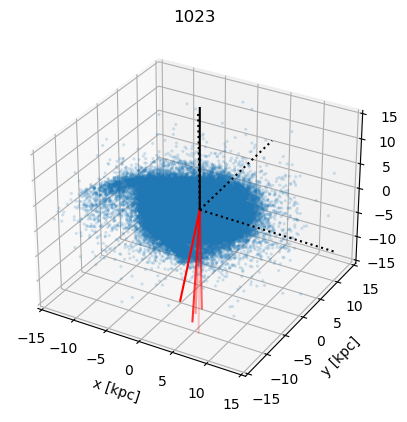

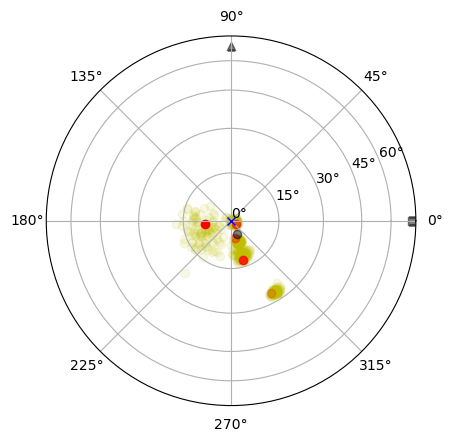

In [60]:
disky_idx = 17 # index of halo in array "diskyIDs" that you want briggs figure for 
GrNr = disky_GrNr[disky_idx]
subfindID = diskyIDs[disky_idx]

theta,phi,raxis,minor,major,inter = get_briggs(GrNr, subfindID, True, False)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Ring angular momentum axes. More transparent = larger ring radii
for i in np.arange(len(phi)):
    if i == 1:
        ax.plot(phi[i], np.sin(theta[i]), 'or', alpha=1-i/5, label='Ring Angular Momentum', zorder=1)
    else:
        ax.plot(phi[i], np.sin(theta[i]), 'or', alpha=1-i/5, zorder=1)
    
# Figure rotation axis, should be at center
ax.plot(raxis[1], np.sin(raxis[0]), 'xb',label='Figure Rotation')

# Halo principal axes
ax.scatter(minor[1], np.sin(minor[0]), color='k', marker='o',alpha=0.5, label='Minor')
ax.scatter(inter[1], np.sin(inter[0])-0.05, color='k', marker='^',alpha=0.5, label='Intermediate')
ax.scatter(major[1], np.sin(major[0])-0.02, color='k', marker='s',alpha=0.5, label='Major')

### If you have bootstrapping data ---------------------------------------------------------------
#for boot_theta, boot_phi in zip(spins_theta,spins_phi):
    #ax.plot(boot_phi, np.sin(boot_theta), 'oy', alpha=.1, zorder=-1)
# ------------------------------------------------------------------------------------------------

# weights the inner regions more to match what you would view from eye
ax.set_rticks(np.sin(np.deg2rad([0,15,30,45,60])), labels=['0°','15°','30°','45°','60°'])
ax.set_rlim([0,1])
plt.legend(loc=(1,1))
title = 'GrNr = ' + str(GrNr)
ax.set_title(title)